In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calpred
import seaborn as sns

# Data simulation
White blood cell count has two components:
1. Genetic component that has nothing to do with disease.
2. Environmental component that involves physical state.
3. Two groups of individuals, one group of individuals have lower environmental component (we need to classify them)

# Evaluation
1. Prioritize based on raw phenotype values.
2. Prioritize based on regressed values.
3. Compare mis-diagnosis rate.

In [2]:
# Generate data

np.random.seed(1234)

n_normal = 20000
n_disease = 400  # 2% prevalence
g1 = np.random.normal(size=n_normal)
r1 = np.random.normal(size=n_normal)
y1 = g1 + r1

g2 = np.random.normal(size=n_disease)
r2 = np.random.normal(size=n_disease) - 2
y2 = g2 + r2

df = pd.concat(
    [
        pd.DataFrame({"g": g1, "r": r1, "y": y1, "group": "normal"}),
        pd.DataFrame({"g": g2, "r": r2, "y": y2, "group": "disease"}),
    ],
    axis=0,
).reset_index(drop=True)

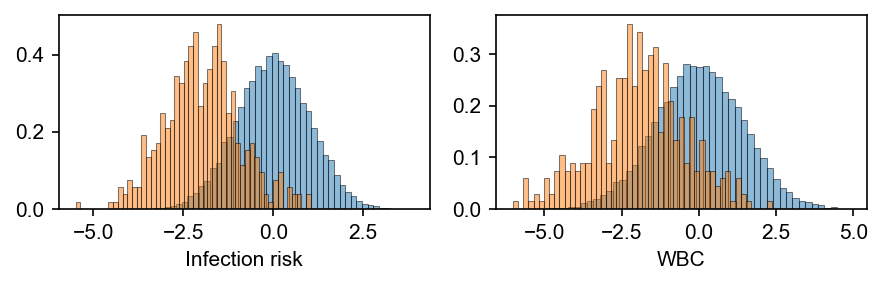

In [3]:
fig, axes = plt.subplots(figsize=(6, 2), dpi=150, ncols=2)
ax = axes[0]
ax.hist(r1, bins=50, linewidth=0.5, edgecolor="black", alpha=0.5, density=True)
ax.hist(r2, bins=50, linewidth=0.5, edgecolor="black", alpha=0.5, density=True)
ax.set_xlabel("Infection risk")

ax = axes[1]
ax.hist(y1, bins=50, linewidth=0.5, edgecolor="black", alpha=0.5, density=True)
ax.hist(y2, bins=50, linewidth=0.5, edgecolor="black", alpha=0.5, density=True)
ax.set_xlabel("WBC")
plt.tight_layout()
plt.show()

In [4]:
# fit model
x, z = sm.add_constant(df[["g"]]), sm.add_constant(df[[]])
model = calpred.fit(y=df["y"], x=x, z=z)
df["pred_mean"], df["pred_sd"] = calpred.predict(x=x, z=z, model_fit=model)
df["pred_low"] = df["pred_mean"] - df["pred_sd"] * 1.645
df["pred_high"] = df["pred_mean"] + df["pred_sd"] * 1.645
df["pred_z"] = (df["y"] - df["pred_mean"]) / df["pred_sd"]

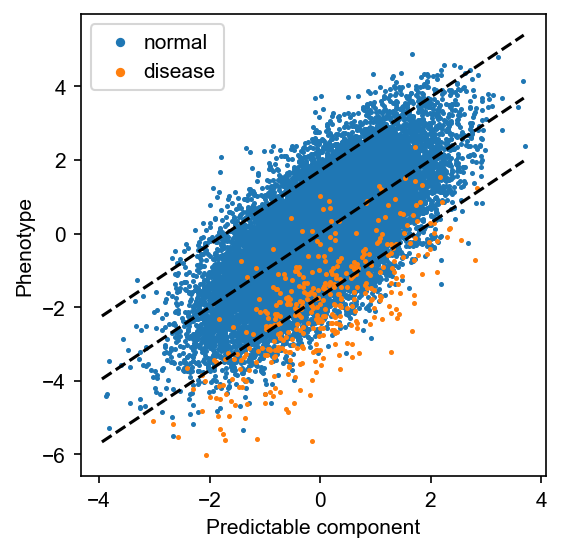

In [5]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

for group in ["normal", "disease"]:
    group_df = df[df["group"] == group]
    ax.scatter(x=group_df["g"], y=group_df["y"], s=2, label=group)

sorted_df = df.sort_values("pred_mean")
for i in [-1, 0, 1]:
    ax.plot(
        sorted_df["pred_mean"],
        sorted_df["pred_mean"] + sorted_df["pred_sd"] * 1.645 * i,
        color="black",
        ls="--",
    )

ax.set_xlabel("Predictable component")
ax.set_ylabel("Phenotype")

legend = ax.legend(handletextpad=0.1)

for handle in legend.legend_handles:
    handle.set_sizes([12])

Text(0, 0.5, 'WBC measured value')

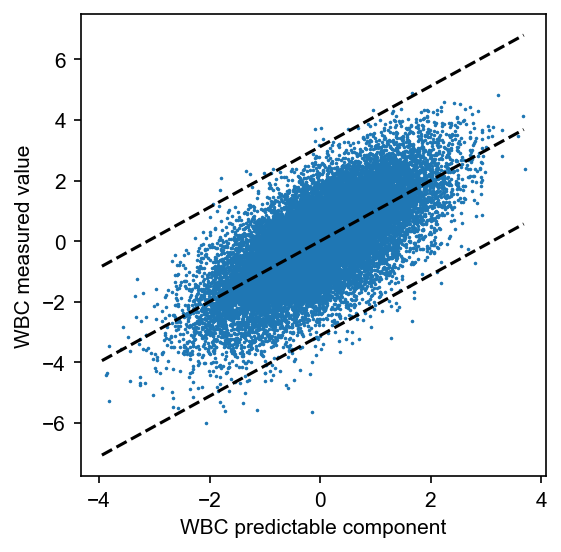

In [6]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

ax.scatter(x=df["g"], y=df["y"], s=0.5)

sorted_df = df.sort_values("pred_mean")
for i in [-1, 0, 1]:
    ax.plot(
        sorted_df["pred_mean"],
        sorted_df["pred_mean"] + sorted_df["pred_sd"] * 3 * i,
        color="black",
        ls="--",
    )


ax.set_xlabel("WBC predictable component")
ax.set_ylabel("WBC measured value")

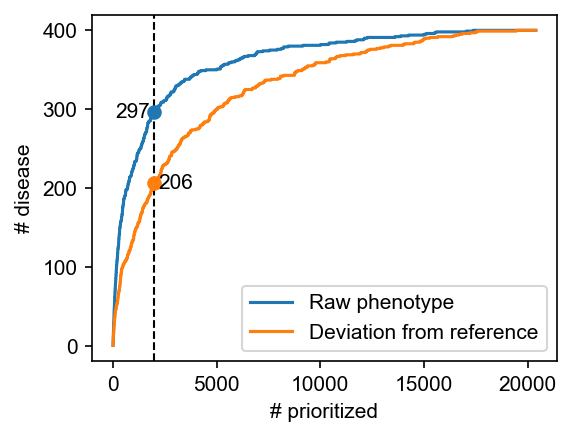

In [7]:
# x-axis: number of prioritized individuals
# y-axis: number of mis-diagnosed individuals

n1 = (df.sort_values("pred_z")["group"] == "disease").cumsum()
n2 = (df.sort_values("y")["group"] == "disease").cumsum()

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.plot(np.arange(len(df)), n1.values, label="Raw phenotype")
ax.plot(np.arange(len(df)), n2.values, label="Deviation from reference")


threshold = 2000


annot1 = n1.values[threshold]
annot2 = n2.values[threshold]

ax.scatter(x=threshold, y=annot1, color="C0")
ax.scatter(x=threshold, y=annot2, color="C1")

ax.annotate(
    f"{annot1}",
    xy=(threshold, annot1),
    xytext=(threshold - threshold / 10, annot1),
    ha="right",
    va="center",
)
ax.annotate(
    f"{annot2}",
    xy=(threshold, annot2),
    xytext=(threshold + threshold / 10, annot2),
    ha="left",
    va="center",
)
ax.axvline(x=threshold, ls="--", color="black", lw=1, zorder=-1)

ax.set_xlabel("# prioritized")
ax.set_ylabel("# disease")
ax.legend()

In [8]:
# strategy one: select high risk individuals with y < 5% quantile as threshold
# strategy two: select high risk individuals with pred_z < 5% quantile as threshold

# group by g into 10 bins
# determine number of individuals selected by each strategy
# and proportion of false positive with positive label determined with disease in group column

In [9]:
# Binning the 'g' variable into 10 bins using qcut
df["g_bin"] = pd.qcut(df["g"], 10, labels=False)

# Applying the strategies
df["pr1"] = df["y"] < df["y"].quantile(0.05)
df["pr2"] = df["pred_z"] < df["pred_z"].quantile(0.05)

# Grouping the df by the bins and calculating the required metrics
grouped_df = df.groupby("g_bin").apply(
    lambda df: pd.Series(
        {
            "n1": df["pr1"].mean(),
            "n2": df["pr2"].mean(),
            "fpr1": (df.loc[df["pr1"], "group"] == "normal").sum() / len(df),
            "fpr2": (df.loc[df["pr2"], "group"] == "normal").sum() / len(df),
        }
    )
)

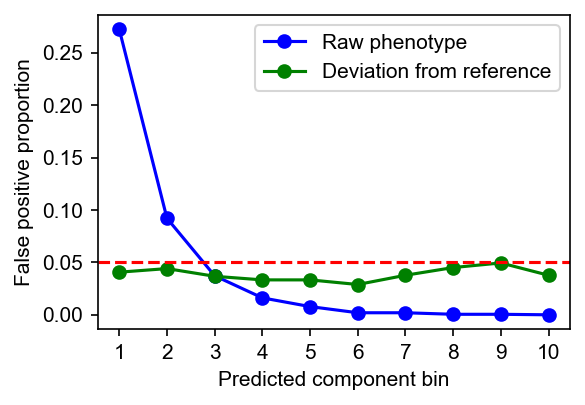

In [10]:
# grouped_df = grouped_df.fillna(0)

# Creating dot plots
fig, ax = plt.subplots(figsize=(4, 2.8), dpi=150)

ax.plot(
    grouped_df.index,
    grouped_df["fpr1"],
    "bo-",
    label="Raw phenotype",
)
ax.plot(
    grouped_df.index,
    grouped_df["fpr2"],
    "go-",
    label="Deviation from reference",
)

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10) + 1)
ax.set_xlabel("Predicted component bin")
ax.set_ylabel("False positive proportion")
ax.axhline(y=0.05, color="red", ls="--")
ax.legend()
plt.tight_layout()
plt.show()